In [1]:
import gym # openAi gym
import numpy as np
import tensorflow as tf
from gym import envs
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
np.random.seed(1)
tf.set_random_seed(1)

# Deep Q Network off-policy
class DeepQNetwork:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=300,
            memory_size=500,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
            layers=[10]
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.hidden_layer_sizes = layers
        #self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max
        
        if e_greedy_increment is not None:
            self.epsilon = 0
        else:
            self.epsilon = self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))
        #print("self.memory: ", self.memory.shape) #self.memory:  (2000, 6)
        self.memory_counter = 0

        # consist of [target_net, evaluate_net]
        self._build_net()
        t_params = tf.get_collection('target_net_params')
        print("t_params: ", t_params)
        e_params = tf.get_collection('eval_net_params')    
        print("e_params: ", e_params)
        
        # all tensors
        #print("tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES): ", tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
        
        # tf.assign(ref, value): Update 'ref' by assigning 'value' to it
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            # tf.train.SummaryWriter soon be deprecated, use following
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []

    def _build_net(self):
        # ------------------ build evaluate_net ------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input
        print("self.s: ", self.s)
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss
        print("self.q_target: ", self.q_target)
        
        
        with tf.variable_scope('eval_net'):
            # c_names(collections_names) are the collections to store variables
            c_names = ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES]
            w_initializer = tf.random_normal_initializer(0., 0.3)
            b_initializer = tf.constant_initializer(0.1)  # config of layers
            print("c_names, w_initializer, b_initializer: ", c_names, w_initializer, b_initializer)
            
            # collections is used later when assign to target net
            for i in range(1, len(self.hidden_layer_sizes)+1):
                if i == 1:
                    with tf.variable_scope('layer'+str(i)):
                        w = tf.get_variable('w'+str(i), [self.n_features, self.hidden_layer_sizes[i-1]], initializer=w_initializer, collections=c_names)
                        b = tf.get_variable('b'+str(i), [1, self.hidden_layer_sizes[i-1]], initializer=b_initializer, collections=c_names)
                        net = tf.nn.relu(tf.matmul(self.s, w) + b)
                        print('layer'+str(i), net)
                else:
                    with tf.variable_scope('layer'+str(i)):
                        w = tf.get_variable('w'+str(i), [self.hidden_layer_sizes[i-2], self.hidden_layer_sizes[i-1]], initializer=w_initializer, collections=c_names)
                        b = tf.get_variable('b'+str(i), [1, self.hidden_layer_sizes[i-1]], initializer=b_initializer, collections=c_names)
                        net = tf.nn.relu(tf.matmul(net, w) + b)
                        print('layer'+str(i), net)
            # last layer. collections is used later when assign to target net
            with tf.variable_scope('final_layer'):
                w = tf.get_variable('w_final_layer', [self.hidden_layer_sizes[-1], self.n_actions], initializer=w_initializer, collections=c_names)
                b = tf.get_variable('b_final_layer', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_eval = tf.matmul(net, w) + b
                print("self.q_eval: ", self.q_eval)
                
            
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
            print("self.loss: ", self.loss)
            
        with tf.variable_scope('train'):
            #self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)
            self._train_op = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss)
            #print("self._train_op: ", self._train_op)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')    # input
        print("self.s_: ", self.s_)
        with tf.variable_scope('target_net'):
            # c_names(collections_names) are the collections to store variables
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            for i in range(1, len(self.hidden_layer_sizes)+1):
                if i == 1:
                    with tf.variable_scope('layer'+str(i)):
                        w = tf.get_variable('w'+str(i), [self.n_features, self.hidden_layer_sizes[i-1]], initializer=w_initializer, collections=c_names)
                        b = tf.get_variable('b'+str(i), [1, self.hidden_layer_sizes[i-1]], initializer=b_initializer, collections=c_names)
                        net = tf.nn.relu(tf.matmul(self.s_, w) + b)
                        print('layer'+str(i), net)
                else:
                    with tf.variable_scope('layer'+str(i)):
                        w = tf.get_variable('w'+str(i), [self.hidden_layer_sizes[i-2], self.hidden_layer_sizes[i-1]], initializer=w_initializer, collections=c_names)
                        b = tf.get_variable('b'+str(i), [1, self.hidden_layer_sizes[i-1]], initializer=b_initializer, collections=c_names)
                        net = tf.nn.relu(tf.matmul(net, w) + b)
                        print('layer'+str(i), net)
            # last layer. collections is used later when assign to target net
            with tf.variable_scope('final_layer'):
                w = tf.get_variable('w_final_layer', [self.hidden_layer_sizes[-1], self.n_actions], initializer=w_initializer, collections=c_names)
                b = tf.get_variable('b_final_layer', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_next = tf.matmul(net, w) + b
                print("self.q_next: ", self.q_next)

    def choose_action(self, observation):
        """
        observation = np.array([-0.5, -0.5])
        print("observation: ", observation.shape) #observation:  (2,)
        observation = observation[np.newaxis, :]
        print("observation: ", observation.shape) #observation:  (1, 2)
        """
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]
        
        """
        np.random.uniform(): [0, 1)
        """
        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
            #print("actions_value: ", actions_value)
            #print("action: ", action)
        else:
            # Explore
            action = np.random.randint(low=0, high=self.n_actions)
        return action
    
    
    def store_transition(self, s, a, r, s_):
#         if not hasattr(self, 'memory_counter'):
#             self.memory_counter = 0

        #transition = np.hstack((s, [a, r], s_))
        transition = np.hstack((s, a, r, s_))
        #print("transition: ", transition) #[-0.5 -0.5  0.   0.  -0.5 -0.5]

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        #print("index: ", index)
        self.memory[index, :] = transition

        self.memory_counter += 1
        #print("self.memory_counter: ", self.memory_counter) # from 0 until 'game over'
        
        
    def learn(self):
        # check to replace target parameters
        # Update target network every self.replace_target_iter (e.g. 200) times
        if self.learn_step_counter % self.replace_target_iter == 0:
            #print("self.learn_step_counter: ", self.learn_step_counter)
            #print("self.cost_his: ", len(self.cost_his))
            self.sess.run(self.replace_target_op)
            print('target_params_replaced\n')

        # sample batch memory from all memory
        """
        Why taking random memory instead of all the memory - batch_size?
        """
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            #print("self.memory_counter: ", self.memory_counter)
            # this is only for first 200 to 2000 memories
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]
        #print("batch_memory: ", batch_memory.shape) #batch_memory:  (32, 6)
        #print("batch_memory 1: ", batch_memory[0]) #batch_memory 1:  [-0.5   0.25  0.    0.   -0.5   0.  ]
        #print("batch_memory 2: ", batch_memory[0, -self.n_features:]) #batch_memory 2:  [-0.5  0. ]
        #print("batch_memory 3: ", batch_memory[0, :self.n_features]) #batch_memory 3:  [-0.5   0.25]

        q_next, q_eval = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={
                self.s_: batch_memory[:, -self.n_features:],  # fixed params
                self.s: batch_memory[:, :self.n_features],  # newest params
            })

        # change q_target w.r.t q_eval's action
        q_target = q_eval.copy()
        #print("q_target.shape: ", q_target.shape) #q_target:  (32, 4)

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int) # actions
        #print("eval_act_index.shape: ", eval_act_index.shape) #eval_act_index.shape:  (32,)
        reward = batch_memory[:, self.n_features + 1] # rewards
        #print("reward.shape: ", reward.shape) #reward.shape:  (32,)
        
        """
        WRONG:
        q_target[batch_index, eval_act_index] - Q value of action taken
        We replace this Q value with reward of current state + Q value of next state
        
        We are trying to minimize the distance between Q values of current state and Q values of next state,
        but because we are adding reward (reward + self.gamma * np.max(q_next, axis=1))
        the distance becomes larger when reward is bigger and reducing this distance leads us to higher rewards.    
        
        1. q_eval: Delete the Q value of the action taken
        2. q_target: For deleted Q value, use the Q value of corresponding action of next state:
            reward + self.gamma * np.max(q_next, axis=1)
        3. q_eval - q_target
        4. Minimize
        """
        #print("q_target[0]: ", q_target[0])
        #print("eval_act_index[0]: ", eval_act_index[0])
        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis=1)

        """
        For example in this batch I have 2 samples and 3 actions:
        q_eval =
        [[1, 2, 3],
         [4, 5, 6]]

        q_target = q_eval =
        [[1, 2, 3],
         [4, 5, 6]]

        Then change q_target with the real q_target value w.r.t the q_eval's action.
        For example in:
            sample 0, I took action 0, and the max q_target value is -1;
            sample 1, I took action 2, and the max q_target value is -2:
        q_target =
        [[-1, 2, 3],
         [4, 5, -2]]

        So the (q_target - q_eval) becomes:
        [[(-1)-(1), 0, 0],
         [0, 0, (-2)-(6)]]

        We then backpropagate this error w.r.t the corresponding action to network,
        leave other action as error=0 cause we didn't choose it.
        """

        # train eval network
        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)

        # increasing epsilon
        #self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        if self.epsilon < self.epsilon_max:
            #print("increasing epsilon")
            self.epsilon = self.epsilon + self.epsilon_increment
        else:
            self.epsilon = self.epsilon_max
        
        self.learn_step_counter += 1

        
    def plot_cost(self):
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
env.n_actions:  Discrete(3)
env.n_features:  Box(2,)
action_space:  3
observation_space:  2
observation_space - high:  [0.6  0.07]
observation_space: - low:  [-1.2  -0.07]
self.s:  Tensor("s:0", shape=(?, 2), dtype=float32)
self.q_target:  Tensor("Q_target:0", shape=(?, 3), dtype=float32)
c_names, w_initializer, b_initializer:  ['eval_net_params', 'variables'] <tensorflow.python.ops.init_ops.RandomNormal object at 0x000001B8AF6A77B8> <tensorflow.python.ops.init_ops.Constant object at 0x000001B8AF6A77F0>
layer1 Tensor("eval_net/layer1/Relu:0", shape=(?, 100), dtype=float32)
layer2 Tensor("eval_net/layer2/Relu:0", shape=(?, 100), dtype=float32)
layer3 Tensor("eval_net/layer3/Relu:0", shape=(?, 100), dtype=float32)
self.q_eval:  Tensor("eval_net/final_layer/add:0", shape=(?, 3), dtype=float32)
self.loss:  Tensor("loss/Mean:0", shape=(), dtype=float32)
self.s_:  Tensor("s_:0", shape=(?, 2), d

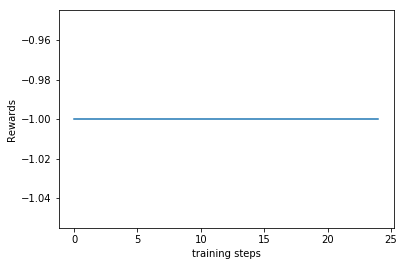

In [3]:
# Classic control
#env = gym.make('CartPole-v1')
#env = gym.make('Pendulum-v0') # Not Working, requires changes in `action` before using `step`
env = gym.make('MountainCar-v0')
#env = gym.make('Acrobot-v1')

# MuJoCo
#env = gym.make('Swimmer-v2') # action_space: 2, observation_space: 8
#env = gym.make('Hopper-v2') # action_space: 3, observation_space:  11
#env = gym.make('Walker2d-v2') # action_space: 6, observation_space: 17
#env = gym.make('HalfCheetah-v2') # action_space: 6, observation_space: 17
#env = gym.make('Ant-v2') # action_space: 8, observation_space: 111
#env = gym.make('HumanoidStandup-v2') # action_space: 17, observation_space: 376
#env = gym.make('Humanoid-v2') # action_space: 17, observation_space: 376

# Robotics
#env = gym.make('FetchPickAndPlace-v1')
#env = gym.make('FetchPush-v1')


#env = env.unwrapped

print("env.n_actions: ", env.action_space)
print("env.n_features: ", env.observation_space)

try:
    num_actions = env.action_space.n
except:
    num_actions = env.action_space.shape[0]
num_observations = env.observation_space.shape[0]

print("action_space: ", num_actions)
print("observation_space: ", num_observations)
print("observation_space - high: ", env.observation_space.high)
print("observation_space: - low: ", env.observation_space.low)

tf.reset_default_graph()
RL = DeepQNetwork(num_actions, num_observations,
                      learning_rate=0.001, #0.01,
                      reward_decay=0.9,
                      e_greedy=0.9,
                      replace_target_iter=200,
                      memory_size=2000,
                      batch_size=200,
                      # output_graph=True
                      layers=[100, 100, 100])

step = 0
episodes = 25
rewards_in_episode = []

for episode in range(episodes):
    # initial observation
    observation = env.reset()
    #print("observation: ", observation) # [-0.5, -0.5]
    
    rewards = []
    while True:
        # fresh env
        #env.render()

        # RL choose action based on observation and current network parameters
        action = RL.choose_action(observation)
        #print("action: ", action)

        # RL take action and get next observation and reward
        observation_, reward, done, info = env.step(action)
        #print("observation_, reward, done: ", observation_, reward, done) #[-0.5 -0.5] 0 False
        rewards.append(reward)
        #print("reward: ", reward)

        # swap observation
        observation = observation_

        # break while loop when end of this episode
        if done:
            break
        step += 1
        
    rewards_mean = np.mean(np.array(rewards))
    rewards_in_episode.append(rewards_mean)

# end of game
print('game over')
env.close()

plt.plot(np.arange(episodes), rewards_in_episode)
plt.ylabel('Rewards')
plt.xlabel('training steps')
plt.show()

episode:  0
reward:  -1.0
target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

episode:  100
reward:  -1.0
target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_par

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

episode:  1700
reward:  -1.0
target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

target_params_replaced

episode:  1800
reward:  -1.0
target_params_replaced

target

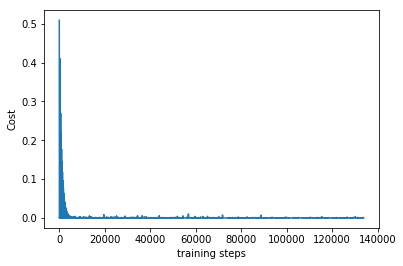

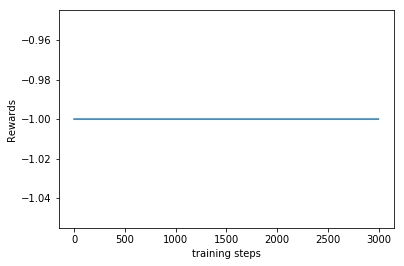

In [5]:
step = 0
episodes = 3000
rewards_in_episode = []

for episode in range(3000):
    if episode % 100 == 0:
        print("episode: ", episode)
        print("reward: ", reward)
    # initial observation
    observation = env.reset()
    #print("observation: ", observation) # [-0.5, -0.5]
    
    rewards = []
    while True:
        # fresh env
        #env.render()

        # RL choose action based on observation and current network parameters
        action = RL.choose_action(observation)
        #print("action: ", action)

        # RL take action and get next observation and reward
        #observation_, reward, done = env.step(action)
        #observation_, reward, done, info = env.step(action)
        observation_, reward, done, info = env.step(np.array(action))
        #print("observation_, reward, done: ", observation_, reward, done) #[-0.5 -0.5] 0 False
        rewards.append(reward)
        #print("reward: ", reward)

        RL.store_transition(observation, action, reward, observation_)

        # learn only when there are at least 200 memory and (step % 5 == 0)
        if (step > 200) and (step % 5 == 0):
            RL.learn()

        # swap observation
        observation = observation_

        # break while loop when end of this episode
        if done:
            break
        step += 1
        
    rewards_mean = np.mean(np.array(rewards))
    rewards_in_episode.append(rewards_mean)

# end of game
print('game over')
env.close()

RL.plot_cost()

plt.plot(np.arange(episodes), rewards_in_episode)
plt.ylabel('Rewards')
plt.xlabel('training steps')
plt.show()